In [ ]:
#this notebook solves for the equilibrium of the Aiyagari model using the endogenous grid method

In [2]:
using Parameters, Plots, LinearAlgebra, Interpolations

Household = @with_kw (apoints = 500, #asset grid
    amax = 200,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2]) # income grid


##NamedTuple_kw#254 (generic function with 2 methods)

In [3]:
# Some helper constructor functions for the household tuple.
#### 1. Rowenhort's method to approximate AR(1) process with Markov chain
#### 2. Functions to construct grids over the state space

function rowenhorst(mean, uncond_sd, rho, num_states)
    """
    Rowenhort's method to approximate AR(1) process with Markov chain
    
    #### Fields
    
    - 'mean': unconditional mean of income process
    - 'uncond_sd': unconditional standard deviation
    - 'rho': autocorrelation coefficient
    - 'num_states': number of states we want discretized
    
    #### Returns
    
    - 'transition_matrix': num_states x num_states array where
    transition_matrx[i,j] is prob. of going from i to j
    - 'ygrid': vector of income state space of length num_states
    
    """
    
    # construct grids
    step_r = uncond_sd*sqrt(num_states-1)
    ygrid = -1:2/(num_states-1):1
    ygrid = mean .+ step_r*ygrid
    
    # initialize transition probabilities 
    p = (rho+1)/2
    q = p
    
    transition_matrix = [p 1-p; 1-q q]
    
    # rowenhort's method
    for i = 2:num_states-1
        a1 = [transition_matrix zeros(i, 1); zeros(1, i+1)] 
        a2 = [zeros(i,1) transition_matrix; zeros(1, i+1)]
        a3 = [zeros(1, i+1); transition_matrix zeros(i,1)]
        a4 = [zeros(1, i+1); zeros(i,1) transition_matrix]
        
        transition_matrix = p*a1 + (1-p)*a2 + (1-q)*a3 + q*a4
        transition_matrix[2:i, :] = transition_matrix[2:i, :]/2
    end
    
    for i = 1:num_states
       transition_matrix[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])
    end
    
    # get stationary distribution to normalize effective labour to L=1
    pi = eigvecs(transition_matrix')[:,num_states]
    
    # normalize pi
    pi = pi./sum(pi)
    
    # exponentiate
    ygrid = exp.(ygrid)
    
    # normalize effective labour
    ygrid = ygrid/sum(pi.*ygrid)
    
    return transition_matrix, ygrid
end



setgrids (generic function with 1 method)

In [4]:
function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

setgrids (generic function with 1 method)

In [5]:
hh = Household()

(apoints = 500, amax = 200, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.40080160320641284 0.40080160320641284 … 0.40080160320641284 0.40080160320641284; … ; 199.59919839679358 199.59919839679358 … 199.59919839679358 199.59919839679358; 200.0 200.0 … 200.0 200.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.0225942669471

In [6]:
# marginal utilities and their inverses

up(c,gamma) = c.^(-gamma)
invup(x,gamma) = x.^(-1/gamma)

# euler equation to get current consumption given future interest rate and future consumption grid

function getc(gamma,beta,transition_matrix; rnext,cnext)
    upnext = beta.*(1+rnext).*up(cnext,gamma)*transition_matrix' # future marginal utility
    c = invup(upnext,gamma) # current consumption
    return c
end

# obtain current assets given consumption today defined on asset grid tomorrow

geta(Amat,Ymat; r,w,c) =  1/(1+r).*(c.+Amat.-w.*Ymat)

# obtain aggregates

function getcapital(; policyfun, dist)
    K = reshape(policyfun, (length(dist),1))
    K = sum(K.*dist)
    return K
end

function getconsumption(; cpolicy,dist)
    C = reshape(cpolicy, (length(dist),1)) 
    C = sum(C.*dist)
    return C
end


getconsumption (generic function with 1 method)

In [7]:
#Note: function takes both current and future interest rates as arguments.

function egm(hh; w, cnext, cbinding, r, rnext)
 """
    use endogenous grid method to obtain c_{t} and a_{t} given c_{t+1} 'cnext'
    
    #### Fields
    
    - 'hh': household tuple
    - 'w': wage rate
    - 'cnext': time t+1 consumption grid
    - 'cbinding': consumption grid when borrowing constraint binds
    - 'r': interest rate at time t
    - 'rnext': interest rate at time t+1
    
    #### Returns
    
    - 'c': time t consumption grid
    - 'anext': time t policy function
    
"""
    
@unpack gamma, beta, transition_matrix, Amat, Ymat, num_states = hh

# current policy functions on current grid
c = getc(gamma, beta, transition_matrix; rnext=rnext, cnext=cnext)
a = geta(Amat, Ymat; r=r, w=w, c=c)

cnonbinding = similar(Amat)
    
# get consumption policy function for current grid
for i = 1:num_states
    cnonbinding[:,i] = LinearInterpolation(a[:,i], c[:,i], extrapolation_bc = Line()).(Amat[:,i])
end

# update elements of consumption policy when borrowing constraint binds
# a[1,j] is the level of current assets that induces the borrowing constraint to bind exactly.
# Therefore, whenever current assets are below a[1,j], the borrowing constraint will be STRICTLY binding.
# Note that this uses the monotonicity of the policy rule.

for j = 1:num_states
   c[:,j] = (Amat[:,j] .> a[1,j]) .*cnonbinding[:,j] .+ (Amat[:,j] .<= a[1,j]).*cbinding[:,j]
end
    
# update saving policy function with new consumption function
anext = @. (1+r)*Amat + w*Ymat - c

return c, anext
    
end

egm (generic function with 1 method)

In [8]:
function iterate_egm(hh; r, tol=1e-8, maxiter=1000)
    @unpack deprec, alpha, Amat, Ymat, bc = hh
    
    Z = ((r + deprec)/alpha)^alpha # normalize aggregate income so that Y=1
    w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha)) # wage rate given guess for r
     
    cnext = @. r*Amat+Ymat*w # initial guess for policy function iteration 
    
    cbinding = @. (1+r)*Amat + w*Ymat + bc # get consumption when borrowing constraint binds
    
    dist = 1
    counter = 0
    
    for i=1:maxiter
        c = egm(hh; w=w, rnext=r, r=r, cnext=cnext, cbinding=cbinding)[1]
        if norm(c-cnext,Inf)<tol 
            println("policy function iteration successful!")
            return egm(hh; w=w, rnext=r, r=r, cnext=c, cbinding=cbinding)
        else
            cnext = c
        end
    end
    
    error("no policy function convergence!")
    
end


iterate_egm (generic function with 1 method)

In [10]:
@time iterate_egm(hh, r = 0.1)

policy function iteration successful!
  0.331917 seconds (73.12 k allocations: 365.311 MiB, 12.98% gc time)


([0.07096749424518328 0.09474585074712497 … 0.32374756274362093 0.44736616230505283; 0.0802685772211671 0.10402894671986812 … 0.33296332057926986 0.456566049492291; … ; 4.469192997723292 4.494141840127407 … 4.731285018197259 4.858247293339893; 4.478015411449168 4.502964924185298 … 4.740113894500879 4.867079161438543], [0.15810405476459372 0.25061327583238513 … 1.4605614789125752 2.2427427352778837; 0.589684735315664 0.6822119433866962 … 1.8922274846039804 2.6744246116176993; … ; 215.31899678775943 215.41033552292507 … 216.6121422599319 217.390979840716; 215.75105613756062 215.84239420239425 … 217.04419514715536 217.82302973614443])

In [11]:
function get_kernel(hh; policyfun)
    
"""
    get transition kernel for asset-income distribution using Young's method
    
    #### Fields
    
    - 'hh': household tuple
    - 'policyfun': savings function, array na x ny
    
    #### Returns
    
    - 'kernel': na*ny x na*ny array row-stochastic transition kernel
    
"""

@unpack apoints, Amat, num_states, Ymat, transition_matrix = hh
    
# construct transition matrix without labour stochasticity
Q = zeros(apoints, apoints, num_states)
    
# find which element to interpolate to
findnearest(A,t) = findmin(abs.(A.-t))[2]

# construct matrices to get neighboring indices
next = similar(Amat)
previous = similar(Amat)

for j = 1:num_states
    for k = 1:apoints
        ind = findnearest(Amat[:,j],policyfun[k,j])
            if policyfun[k,j] - Amat[ind,j] > 0
                previous[k,j] = Amat[ind,j]
                if ind == apoints
                    next[k,j] = Amat[ind,j]
                else         
                next[k,j] = Amat[ind+1,j]
                end
            elseif policyfun[k,j] == Amat[ind,j]
                previous[k,j] = policyfun[k,j] 
                next[k,j] = policyfun[k,]
            else
                next[k,j] = Amat[ind,j]
                if ind == 1
                    previous[k,j] = Amat[ind,j]
                else
                    previous[k,j] = Amat[ind-1,j]
                end
            end  
    end
end
    
# construct transition matrix for assets.
# Q[i,j,k] is the probability of going to agrid[i] when current assets are agrid[j] and income is ygrid[k]
for k = 1:apoints
    for j = 1:num_states
        if next[k,j] == previous[k,j]
            Q[Amat[:,1].==previous[k,j],k,j] .= 1
        else
            Q[Amat[:,1].==previous[k,j],k,j] .= (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
            Q[Amat[:,1].==next[k,j],k,j] .= 1 - (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
    
        end
    end
end
    
# construct transition kernel by taking the kronecker product of assets and transition_matrix for income
kernel = zeros(apoints*num_states,apoints*num_states)

for j=1:num_states
    for i=1:num_states
        kernel[(i-1)*apoints+1:i*apoints,(j-1)*apoints+1:j*apoints]=Q[:,:,j].*transition_matrix[j,i];
    end
end

kernel = kernel'
    
return kernel
end

get_kernel (generic function with 1 method)

In [12]:
function get_invariant_dist(hh; kernel, tol=1e-8, maxiter=1000)
    @unpack apoints, num_states = hh
    
    #initial guess for invariant distribution
    init = ones(apoints*num_states)
    init = init./sum(init)
    
    dist = 1
    counter = 0
    
    for i=1:maxiter
        initnext = (init'*kernel)'
        if norm(init-initnext,Inf) < tol 
            println("distribution iteration successful!")
            return initnext
        else
            init = initnext
        end
    end
    
    error("distribution did not convergence!")
end

get_invariant_dist (generic function with 1 method)

In [13]:
function ss(hh; r)
    @unpack beta = hh
    @assert r < 1/(beta)-1 "r too large for convergence"
    
    c, anext = iterate_egm(hh; r = r) # get converged policy function
    kernel = get_kernel(hh; policyfun = anext) # get kernel
    
    invariant_distribution = get_invariant_dist(hh; kernel = kernel) # get invariant distribution
    
    K = getcapital(; policyfun = anext, dist = invariant_distribution) # get aggregate capital
    
    return K
end

ss (generic function with 1 method)

In [14]:
function plot_market_clearing(hh)
    
    @unpack alpha, deprec = hh
    
    rgrid = 0.005:0.002:0.014
    Ksupply = zeros(length(rgrid))
    
    for (index,r) in enumerate(rgrid)
        Ksupply[index] = ss(hh; r=r)
    end
    
    plot(rgrid, Ksupply, label = "capital supply")
    
    Z(r) = ((r + deprec)/alpha)^alpha #normalize so Y=1
    K(r) = ((Z(r)*alpha)/(r+deprec))^(1/(1-alpha))
    
    plot!(rgrid,K.(rgrid), label= "capital demand")
    
end

plot_market_clearing (generic function with 1 method)

policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!


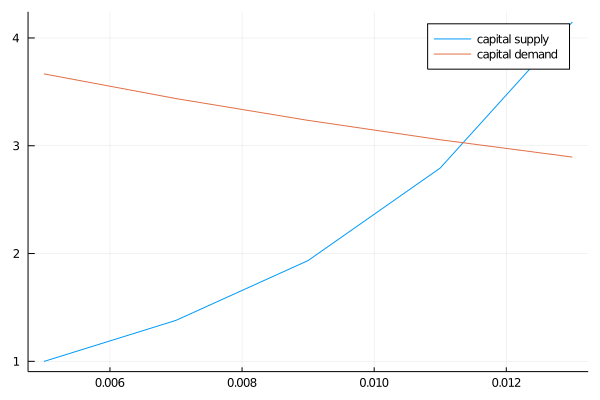

In [16]:
plot_market_clearing(hh)

In [17]:
function market_clearing(hh; r = 0.011, tol = 1e-5, maxiter = 20, bisection_param = 0.8)
    @unpack alpha, deprec = hh
    
    for iter = 1:maxiter
        print("r=$r: ")
        Ksupply = ss(hh; r=r)
    
        Z = ((r + deprec)/alpha)^alpha
        rsupply = Z*alpha*(1/Ksupply)^(1-alpha) - deprec
        
        if abs(r-rsupply) < tol
            return (r+rsupply)/2
        else r = (bisection_param)*r + (1-bisection_param)*rsupply
        end
    end
    
    error("no convergence: did not find market clearing real rate")
end

market_clearing (generic function with 1 method)

In [18]:
market_clearing(hh)

r=0.011: policy function iteration successful!
distribution iteration successful!
r=0.011598145476627797: policy function iteration successful!
distribution iteration successful!
r=0.011335559535202717: policy function iteration successful!
distribution iteration successful!
r=0.01144402913507371: policy function iteration successful!
distribution iteration successful!
r=0.011397948364895279: policy function iteration successful!
distribution iteration successful!
r=0.011417302326479993: policy function iteration successful!
distribution iteration successful!
r=0.011409133617604069: policy function iteration successful!
distribution iteration successful!
r=0.011412573925230521: policy function iteration successful!
distribution iteration successful!


0.011408949490941189